6047
5705
2190
2173


[Text(1, 0, 'hifi-hap1'),
 Text(2, 0, 'ont-hap1'),
 Text(3, 0, 'hifi-hap2'),
 Text(4, 0, 'ont-hap2')]

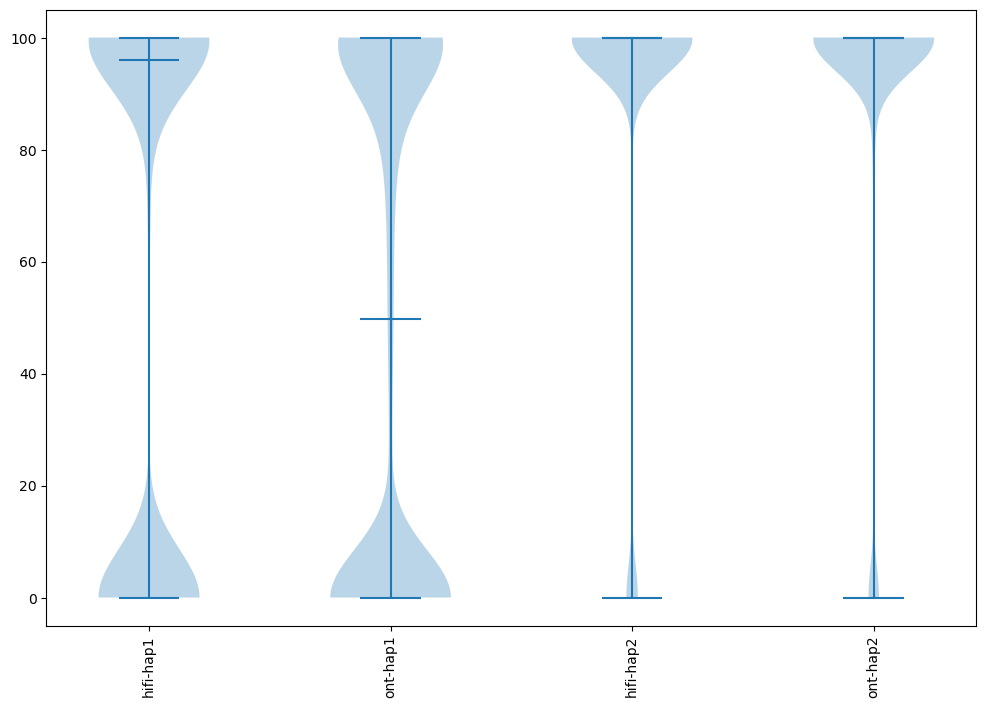

In [15]:
import pathlib as pl
import pandas as pd
import collections as col

import matplotlib as mpl
import matplotlib.pyplot as plt

input_folder = pl.Path("/home/ebertp/work/projects/hgsvc/2023_readassm_align/primcov")

seq_is_tagged = True

dirty_seqs = col.Counter()
nzcov_pct = col.defaultdict(list)
for hdf_file in input_folder.glob("*.h5"):
    with pd.HDFStore(hdf_file, "r") as hdf:
        sample = hdf_file.name.split(".")[0]
        read_type = hdf_file.name.split(".")[2]
        stats = hdf["/statistics"]
        
        for row in stats.itertuples():
            if seq_is_tagged:
                # tag = sort into bucket
                seq_name, seq_tag = row.Index.rsplit(".", 1)
                if seq_tag == "ebv" or seq_tag == "mito":
                    dirty_seqs[(sample, read_type, seq_tag)] += 1
                    continue
                pct = round(row.coverage_nonzero_count / row.seq_length * 100, 1)
                nzcov_pct[(sample, read_type, seq_tag)].append(pct)
            else:
                raise

datapoints = []
labels = []

for au in ["hap1", "hap2"]:  #, "unassigned", "rdna", "disconnected"]:
    for rt in ["hifi", "ont"]:
        
        sample_agg = []
        for sample, read_type, asm_unit in nzcov_pct.keys():
            if read_type != rt or asm_unit != au:
                continue
            sample_agg.extend(nzcov_pct[(sample, rt, au)])
        datapoints.append(sample_agg)
        labels.append(f"{rt}-{au}")    

pos = list(range(1,len(labels)+1))            
for sublist in datapoints:
    print(len(sublist))
fig, ax = plt.subplots(figsize=(12,8))

_ = ax.violinplot(
    datapoints,
    positions=pos,
    showmeans=False,
    showmedians=True
)

ax.set_xticks(pos)
ax.set_xticklabels(labels, rotation=90)